Build **an unsupervised clustering model** to cluster and visualize the text in your dataset. Your implementation must include:
- a **dimensionality reduction** technique (PCA)
- a **clustering algorithm** (k-NN, k-means, Gaussian mixture models, etc.) - you can find an example of how to use a clustering algorithm in the Glove and Clustering Jupyter notebook in week 7's folder.
- a discussion of which vectorization technique performs the best and why (GloVe, TF-IDF, word count, one-hot encoding, word2vec)

In [4]:
import pandas as pd
import numpy as np

In [5]:
data = pd.read_csv("reddit_worldnews_start_to_2016-11-22.csv")

In [41]:
import random 
random.seed(30)
small_sample = data.sample(n =5000).reset_index(drop=True)

In [42]:
titles = small_sample["title"].values

# Preprocessing

In [43]:
# Preprocess the reviews (tokenizing, lemmatization, removing stopwords)
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import string

stop_words = set(stopwords.words('english'))

lemmatizer = WordNetLemmatizer()

def preprocessing(titles):
    filtered_titles = []
    for title in titles:
        title = title.lower()
        token_list = word_tokenize(title) # Tokenize
        filtered_token = [t for t in token_list if not t in stop_words] # Remove stopwords
        for i in range(len(filtered_token)):
            filtered_token[i] = lemmatizer.lemmatize(filtered_token[i]).strip(string.punctuation) # Lemmatization
        filtered_titles.append(" ".join(filtered_token))
    return filtered_titles

In [83]:
filtered_corpus = preprocessing(titles)

In [45]:
len(filtered_corpus)

5000

# Word Count

In [103]:
import sklearn
from sklearn.feature_extraction.text import CountVectorizer

filtered_corpus = preprocessing(titles)
vectorizer = CountVectorizer()

# vectorize the corpus and generate similarity matrix
vector_wordcount = vectorizer.fit_transform(filtered_corpus)

In [166]:
vector_wordcount.shape

(5000, 10084)

## Explained Variance

In [105]:
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(features)
mean_vec = np.mean(X_std, axis=0)
cov_mat = (X_std - mean_vec).T.dot((X_std - mean_vec)) / (X_std.shape[0]-1)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [107]:
sum_var=np.trace(cov_mat)

In [118]:
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

In [153]:
running_total=0
explained_var_list=[]
for i in range(0,len(eig_vals)):
    running_total+=float(eig_vals[i])
    explained_var=running_total/sum_var
    explained_var_list.append((i,explained_var))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  after removing the cwd from sys.path.


In [154]:
explained_var_df=pd.DataFrame(explained_var_list,columns=['Number of Dimensions','Explained Variance Ratio'])

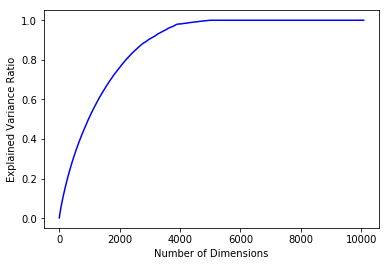

In [159]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.lineplot(explained_var_df['Number of Dimensions'],explained_var_df['Explained Variance Ratio'], color='blue')

In [165]:
explained_var_df[explained_var_df['Explained Variance Ratio']>=0.9].head()

Number of Dimensions  Explained Variance Ratio
2940                  2940                  0.900074
2941                  2941                  0.900195
2942                  2942                  0.900315
2943                  2943                  0.900436
2944                  2944                  0.900556

We need at least 2,940 dimensions to keep 90% variance.

# Covariance Matrix on 2 dimensions

In [191]:
from sklearn.decomposition import PCA
features=vector_wordcount.toarray()

pca = PCA(n_components=2)

pca_fit= pca.fit_transform(features)

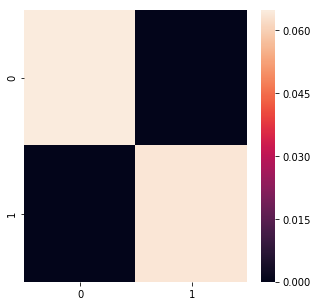

In [50]:
covariances = pd.DataFrame(np.cov(pca_fit.transpose()))
plt.rcParams["figure.figsize"] = (5,5)
sns.heatmap(covariances)

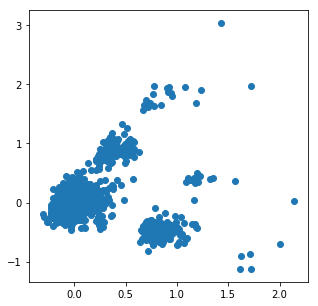

In [51]:
plt.scatter(pca_fit[:,0], pca_fit[:, 1])
reduced_features_df = pd.DataFrame(pca_fit, columns=["x1", "x2"])
reduced_features_df["text"] = titles

In [54]:
#cleaning titles since matplotlib cannot display $$ properly
#titles_clean=[i.replace('$$','$') for i in titles]

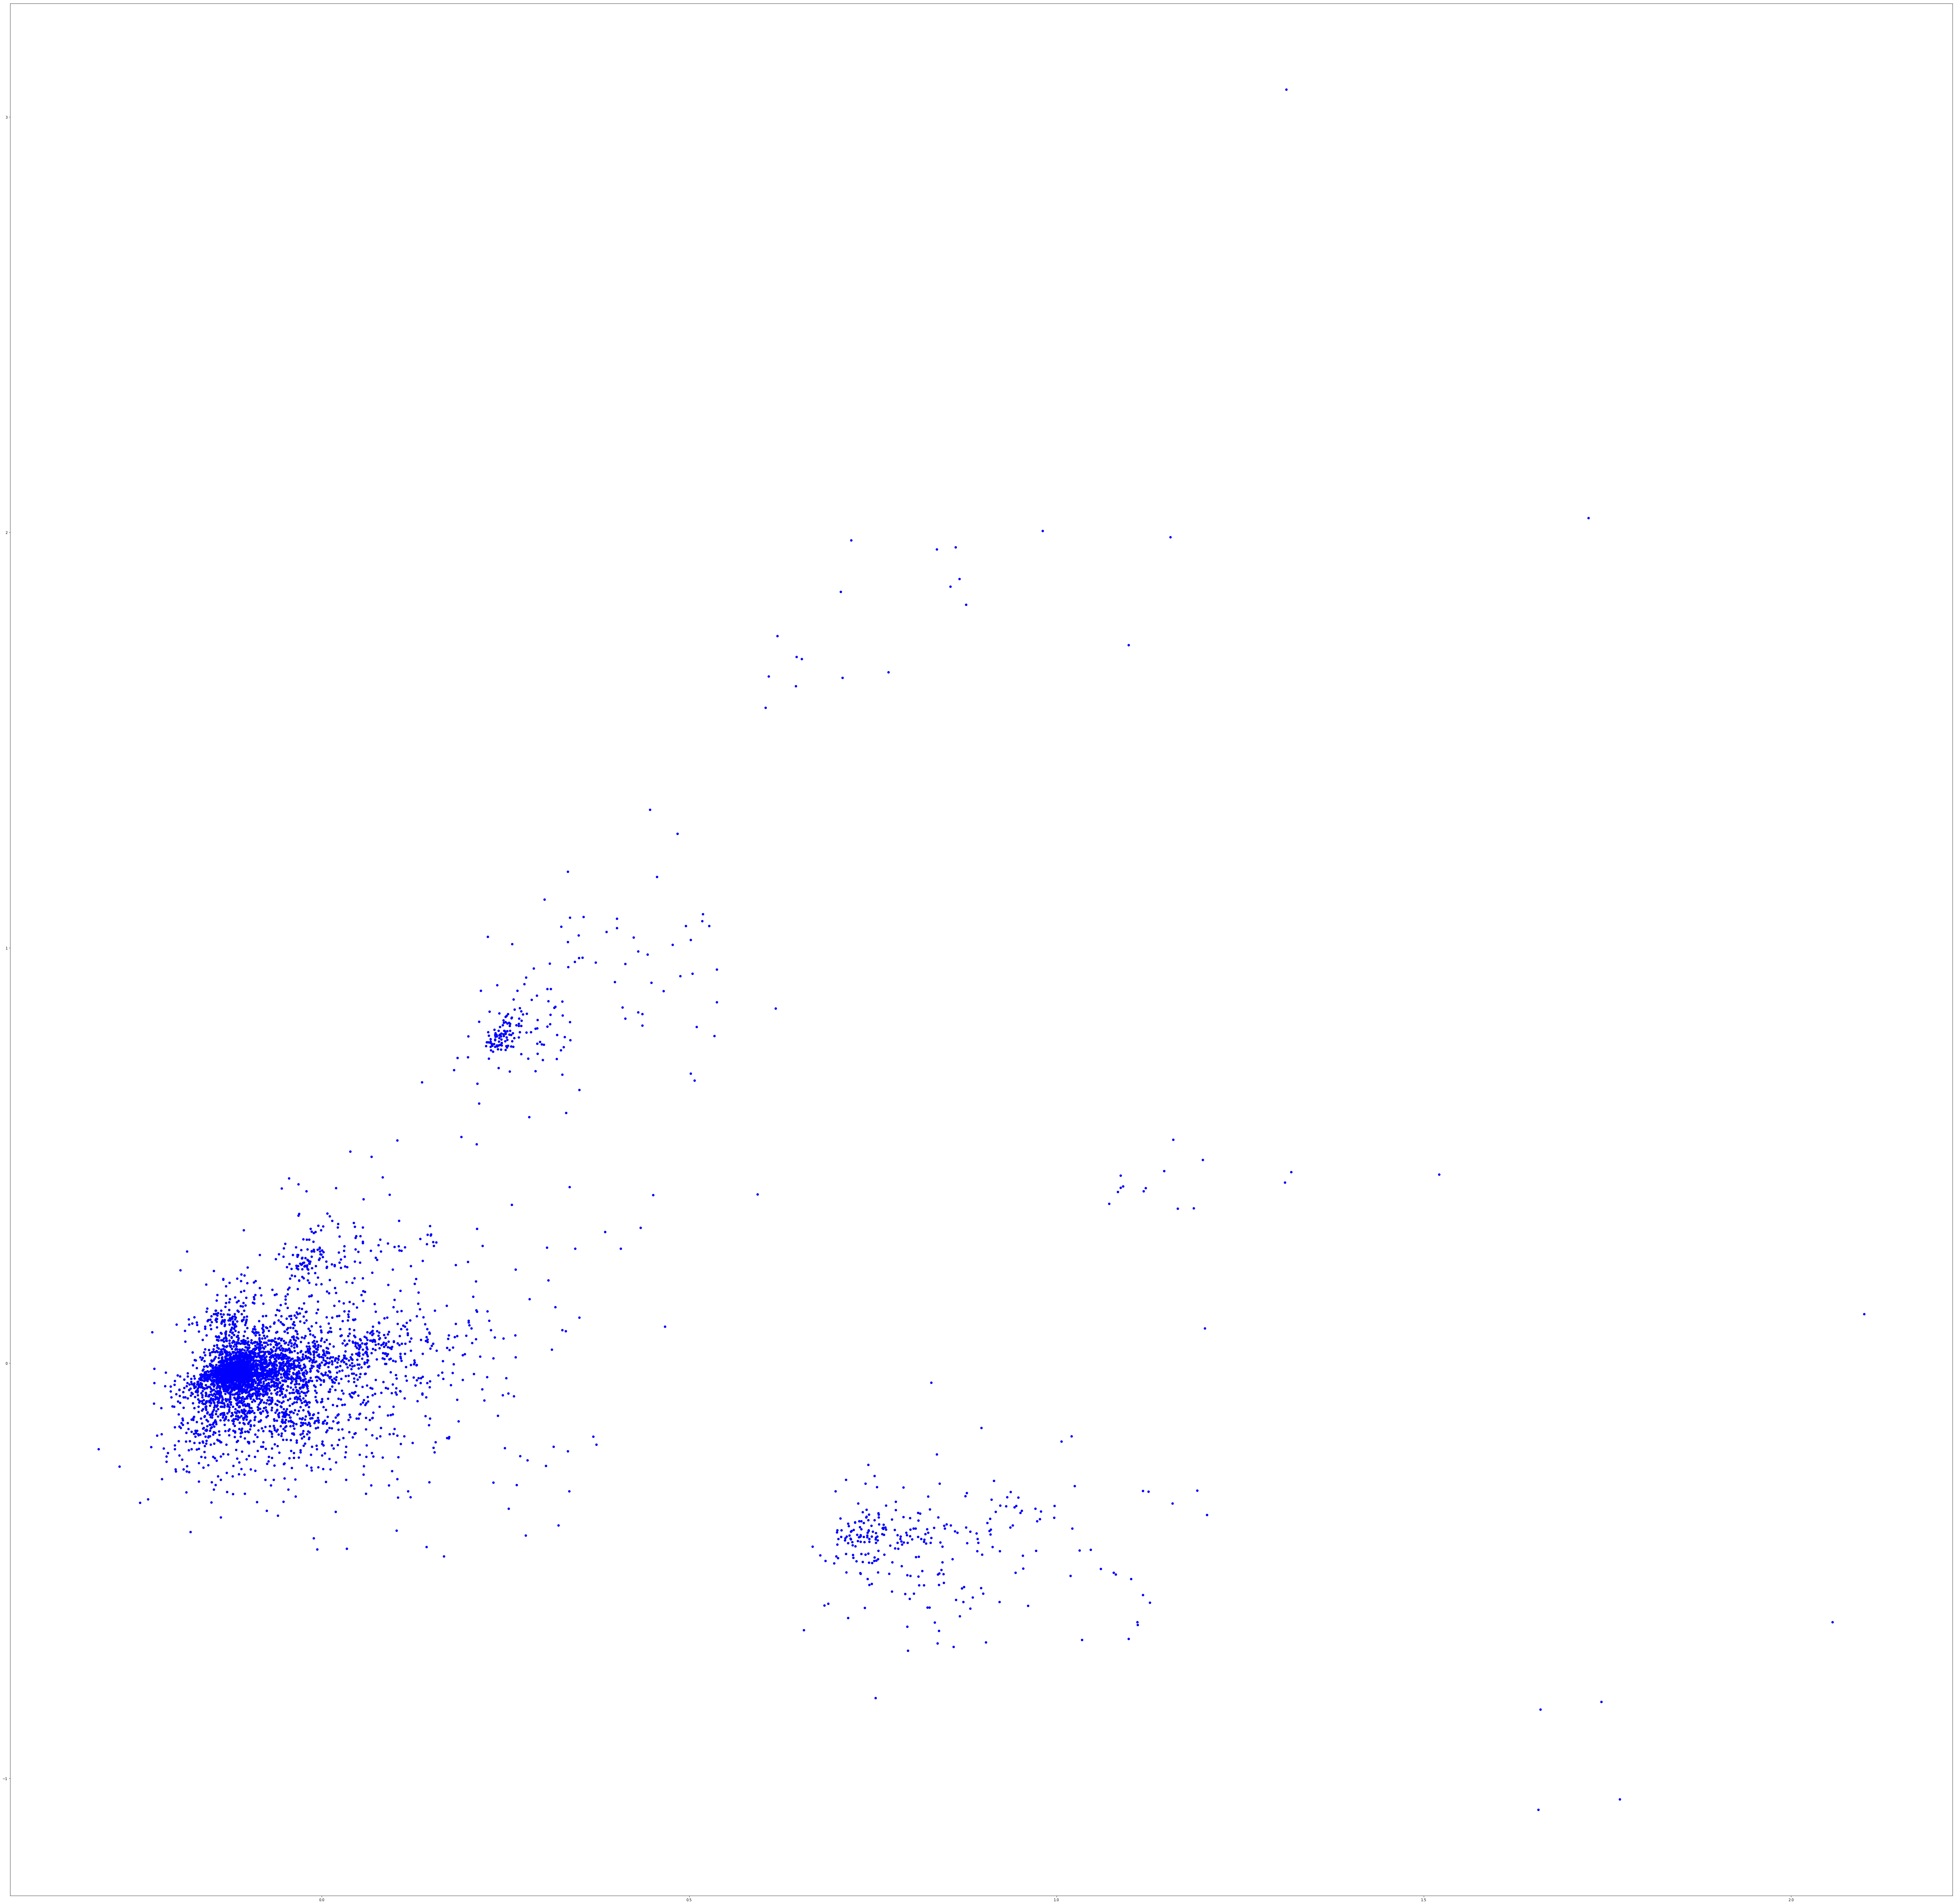

In [160]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (100,100)

for i, vector in enumerate(pca_fit):
    x = vector[0]
    y = vector[1]
    plt.plot(x,y, 'bo')
    #plt.text(x * (1 + 0.01), y * (1 + 0.01) , titles_clean[i], fontsize=12)

# kmeans Clustering

In [167]:
features_df = pd.DataFrame(pca_fit) #using 2 dimensions

In [188]:
from sklearn.cluster import KMeans
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(features_df)
    features_df["clusters"] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center

sns.lineplot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.tick_params(axis='both', which='major', labelsize=5)
plt.show()

In [187]:
sse

{1: 10549.185545152806,
 2: 358.3318911513745,
 3: 134.59652661793615,
 4: 107.29923215301586,
 5: 81.26522253945005,
 6: 67.50980019537437,
 7: 54.97207670148941,
 8: 47.28014800054086,
 9: 42.61344352367861}

In [189]:
kmeans = KMeans(n_clusters=2)
cluster_assignments = kmeans.fit_predict(pca_fit)

color_map = {
    0: "r",
    1: "b"
}

plt.rcParams["figure.figsize"] = (200,100)

for i, vector in enumerate(pca_fit):
    x = vector[0]
    y = vector[1]
    plt.plot(x,y, 'bo', c=color_map[cluster_assignments[i]])
    #plt.text(x * (1 + 0.01), y * (1 + 0.01) , titles_clean[i], fontsize=12)

# One-hot encoding

In [162]:
import sklearn
from sklearn.feature_extraction.text import CountVectorizer

filtered_corpus = preprocessing(titles)
vectorizer = CountVectorizer(binary=True) 

vector_onehot = vectorizer.fit_transform(filtered_corpus)

In [192]:
from sklearn.decomposition import PCA
features=vector_onehot.toarray()

pca = PCA(n_components=2)

pca_fit= pca.fit_transform(features)

features_df = pd.DataFrame(pca_fit) #using 2 dimensions

sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(features_df)
    features_df["clusters"] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center

sse

{1: 562.3559019901476,
 2: 279.9024525147491,
 3: 123.00901197054792,
 4: 86.21061843095464,
 5: 61.694600354834286,
 6: 51.438873803377454,
 7: 43.83881676781784,
 8: 37.587553321700334,
 9: 33.074581345437636}

In [193]:
sns.lineplot(list(sse.keys()), list(sse.values()))

In [194]:
kmeans = KMeans(n_clusters=3)
cluster_assignments = kmeans.fit_predict(pca_fit)

color_map = {
    0: "r",
    1: "b",
    2: "g"
}

plt.rcParams["figure.figsize"] = (200,100)

for i, vector in enumerate(pca_fit):
    x = vector[0]
    y = vector[1]
    plt.plot(x,y, 'bo', c=color_map[cluster_assignments[i]])
    #plt.text(x * (1 + 0.01), y * (1 + 0.01) , titles_clean[i], fontsize=12)

# TF-IDF

In [195]:
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer

filtered_corpus = preprocessing(titles)
vectorizer = TfidfVectorizer(ngram_range=(1,2),
                             token_pattern=r'\b[a-zA-Z]{3,}\b',
                             max_df = 0.4)

# vectorize the corpus and generate similarity matrix
vector_tfidf = vectorizer.fit_transform(filtered_corpus)

In [196]:
from sklearn.decomposition import PCA
features=vector_tfidf.toarray()

pca = PCA(n_components=2)

pca_fit= pca.fit_transform(features)

features_df = pd.DataFrame(pca_fit) #using 2 dimensions

sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(features_df)
    features_df["clusters"] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center

sse

{1: 15.382697125617485,
 2: 8.741212092673234,
 3: 4.720813515389091,
 4: 3.2349941921044656,
 5: 2.5333080890101063,
 6: 2.0258758214021606,
 7: 1.6013447700876202,
 8: 1.3522885792434391,
 9: 1.2123422869790352}

In [197]:
sns.lineplot(list(sse.keys()), list(sse.values()))

In [199]:
kmeans = KMeans(n_clusters=4)
cluster_assignments = kmeans.fit_predict(pca_fit)

color_map = {
    0: "r",
    1: "b",
    2: "g",
    3: "y"
}

plt.rcParams["figure.figsize"] = (200,100)

for i, vector in enumerate(pca_fit):
    x = vector[0]
    y = vector[1]
    plt.plot(x,y, 'bo', c=color_map[cluster_assignments[i]])
    #plt.text(x * (1 + 0.01), y * (1 + 0.01) , titles_clean[i], fontsize=12)

# TF-IDF weighted word2vec

In [200]:
tfidf_matrix=pd.DataFrame(vector_tfidf.toarray(),columns=vectorizer.get_feature_names())
tfidf_matrix.head()

aamer  aamer last  aamir  aamir khan  aap  aap modi  abandon  \
0    0.0         0.0    0.0         0.0  0.0       0.0      0.0   
1    0.0         0.0    0.0         0.0  0.0       0.0      0.0   
2    0.0         0.0    0.0         0.0  0.0       0.0      0.0   
3    0.0         0.0    0.0         0.0  0.0       0.0      0.0   
4    0.0         0.0    0.0         0.0  0.0       0.0      0.0   

   abandon armed  abandon central  abandon chinese     ...       \
0            0.0              0.0              0.0     ...        
1            0.0              0.0              0.0     ...        
2            0.0              0.0              0.0     ...        
3            0.0              0.0              0.0     ...        
4            0.0              0.0              0.0     ...        

   zubaida meeki  zuckerberg  zuckerberg pro  zulfiqar  zulfiqar gunned  zuma  \
0            0.0         0.0             0.0       0.0              0.0   0.0   
1            0.0         0.0             0.0       0.0              0.0   0.0   
2            0.0         0.0             0.0       0.0              0.0   0.0   
3            0.0         0.0             0.0       0.0              0.0   0.0   
4            0.0         0.0             0.0       0.0              0.0   0.0   

   zuma former  zuma three  zwarte  zwarte piet  
0          0.0         0.0     0.0          0.0  
1          0.0         0.0     0.0          0.0  
2          0.0         0.0     0.0          0.0  
3          0.0         0.0     0.0          0.0  
4          0.0         0.0     0.0          0.0  

[5 rows x 48172 columns]

In [201]:
import en_core_web_md
import spacy
from scipy.spatial.distance import cosine
nlp = en_core_web_md.load()
# Word embeddings for each word in the column index of TF-IDF matrix
word2vec = [np.array(nlp(i).vector) for i in tfidf_matrix.columns]

In [202]:
unweighted_matrix = pd.DataFrame(np.dot(tfidf_matrix,np.array(word2vec)))
unweighted_matrix.head()

0         1         2         3         4         5         6    \
0  0.396492 -0.537859  0.915336  0.435891  0.130519 -0.010834  0.828561   
1 -0.651515  1.112896 -0.236116  0.916734  1.102226 -0.598838  0.069084   
2 -0.546088  0.101712  0.117801  0.552771  1.228263 -0.919285 -0.337288   
3 -1.366011 -0.938439  0.900976  0.400452 -0.429178 -1.016246 -0.011436   
4 -0.812563  1.144624  0.552649 -0.165517  0.089771 -0.543367  0.083471   

        7         8          9      ...          290       291       292  \
0  1.039648 -0.040060   5.260703    ...    -1.112267  0.542114  0.810940   
1 -0.044301 -0.256872  12.697358    ...    -0.743880  0.618061 -0.259285   
2  0.290201 -0.356825   9.059939    ...     0.357060  0.244090  0.279234   
3  0.657495 -0.227765   7.746128    ...    -0.628214  0.788201 -0.309593   
4 -0.108031 -0.520295   4.690480    ...     0.261931 -0.045961  0.448888   

        293       294       295       296       297       298       299  
0  0.229882  0.168638 -0.174291  0.013703 -0.182458 -0.547152  1.065089  
1 -0.105381  0.948228 -0.823896 -0.352337 -0.284737 -0.202912  0.987946  
2 -0.924492 -0.263166  0.301539 -0.138377  1.089535 -1.378013  1.067018  
3 -0.422393  0.059587  1.767579  0.150629 -0.161559 -0.785128 -0.481940  
4 -0.087559 -0.298449  0.099143 -1.074078  0.320111 -0.560474  0.679338  

[5 rows x 300 columns]

In [203]:
final_w2v = unweighted_matrix.div(tfidf_matrix.sum(axis=1), axis=0)
final_w2v = final_w2v.fillna(0)
final_w2v.head()

0         1         2         3         4         5         6    \
0  0.102654 -0.139254  0.236984  0.112854  0.033792 -0.002805  0.214518   
1 -0.092652  0.158265 -0.033578  0.130369  0.156748 -0.085161  0.009824   
2 -0.124479  0.023185  0.026852  0.126003  0.279979 -0.209548 -0.076884   
3 -0.333105 -0.228841  0.219705  0.097651 -0.104656 -0.247814 -0.002789   
4 -0.273118  0.384729  0.185756 -0.055633  0.030174 -0.182636  0.028056   

        7         8         9      ...          290       291       292  \
0  0.269169 -0.010372  1.362018    ...    -0.287971  0.140356  0.209956   
1 -0.006300 -0.036530  1.805695    ...    -0.105787  0.087895 -0.036873   
2  0.066150 -0.081337  2.065186    ...     0.081391  0.055640  0.063651   
3  0.160332 -0.055541  1.888910    ...    -0.153191  0.192205 -0.075495   
4 -0.036311 -0.174881  1.576557    ...     0.088040 -0.015448  0.150880   

        293       294       295       296       297       298       299  
0  0.059517  0.043661 -0.045125  0.003548 -0.047239 -0.141660  0.275756  
1 -0.014986  0.134848 -0.117167 -0.050106 -0.040492 -0.028856  0.140496  
2 -0.210735 -0.059988  0.068735 -0.031543  0.248356 -0.314114  0.243224  
3 -0.103002  0.014530  0.431028  0.036731 -0.039397 -0.191455 -0.117522  
4 -0.029430 -0.100314  0.033324 -0.361018  0.107595 -0.188386  0.228338  

[5 rows x 300 columns]

In [102]:
final_w2v.shape

(5000, 300)

In [204]:
from sklearn.decomposition import PCA
features=np.squeeze(np.asarray(final_w2v))

pca = PCA(n_components=2)

pca_fit= pca.fit_transform(features)

features_df = pd.DataFrame(pca_fit) #using 2 dimensions

sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(features_df)
    features_df["clusters"] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center

sse

{1: 4154.324099274323,
 2: 2554.1675602261275,
 3: 1904.7191065212153,
 4: 1464.906630038977,
 5: 1292.0861119196898,
 6: 1135.2547458066742,
 7: 999.7382604562399,
 8: 871.2254334566179,
 9: 787.2381623782176}

In [205]:
sns.lineplot(list(sse.keys()), list(sse.values()))

In [206]:
kmeans = KMeans(n_clusters=3)
cluster_assignments = kmeans.fit_predict(pca_fit)

color_map = {
    0: "r",
    1: "b",
    2: "g"
}

plt.rcParams["figure.figsize"] = (200,100)

for i, vector in enumerate(pca_fit):
    x = vector[0]
    y = vector[1]
    plt.plot(x,y, 'bo', c=color_map[cluster_assignments[i]])
    #plt.text(x * (1 + 0.01), y * (1 + 0.01) , titles_clean[i], fontsize=12)

# Word embeddings

In [ ]:
vector=[nlp(i) for i in filtered_corpus]

# GloVe

In [61]:
from gensim.scripts.glove2word2vec import glove2word2vec
glove_input_file = 'glove.6B.100d.txt'
word2vec_output_file = 'glove.6B.100d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)

(400000, 100)

In [62]:
from gensim.models import KeyedVectors
# load the Stanford GloVe model
filename = 'glove.6B.100d.txt.word2vec'
model = KeyedVectors.load_word2vec_format(filename, binary=False)

In [84]:
filtered_corpus=[sent.replace('-',' ') for sent in filtered_corpus]

In [92]:
#averaging word vectors as sentence vectors
vectors=[]
for sentence in filtered_corpus:
    running_total = np.zeros(100)
    for i in range(0,len(running_total)):
        for token in sentence.split():
            try:
                running_total[i] += model.wv[token][i] # add the word embeddings to the running total
            except:#mean:0; std:0.1; distribution of words
                running_total[i] += np.random.normal(0,0.1,1) #handles out-of-vocabulary issue
    # divide by the total number of words in sentence
    vectors.append(running_total / len(sentence.split()))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
